This Notebook benchmarks read/write speeds and file sizes for different file types and compression algorithms.
i.e.:
- CSV + gzip
- CSV + ZStandard
- Parquet + Snappy
- Parquet + ZStandard.

It is run on a ```Intel(R) Xeon(R) CPU E5-1650 v3 @ 3.50GHz``` / ```128GB RAM``` server with ```Ubuntu 22.04.1 LTS```.

# **Visualized Results @ end of notebook**

In [1]:
import os
import pandas as pd
import lib.mb as mb
import lib.load as load
import time
import config
from pyarrow import parquet as pq, Table as pt

TEST_ROOT = os.path.join(config.WRITE_ROOT, "tests/")
os.makedirs(TEST_ROOT, exist_ok=True)

In [2]:
with open(
    os.path.join(config.SAMPLE_ROOT, 'random_file_paths.txt'), 'r') as f:
    paths = f.readlines()

paths = [path.strip() for path in paths]

# Write times

In [3]:
%%time
snappy_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "snappy_parquet/"), 
    exist_ok=True)

# Writing files in parquet w/ snappy

snappy_write_start = time.monotonic()

for n, file in enumerate(paths):
    df = pd.read_csv(file, sep='\t')
    path =  os.path.join(TEST_ROOT, f"snappy_parquet/{n}_snappy.parquet")
    snappy_paths.append(path)
    df.to_parquet(path, compression='snappy')

snappy_write_end = time.monotonic()

snappy_write_time = round(snappy_write_end - snappy_write_start, 2)
snappy_write_time

CPU times: user 6.41 s, sys: 784 ms, total: 7.2 s
Wall time: 15.1 s


15.12

In [4]:
%%time
zstd_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "zst_parquet/"), 
    exist_ok=True)
# writing files in parquet w/ zstd

zst_parquet_write_start = time.monotonic()
for n, file in enumerate(paths):
    df = pd.read_csv(file, sep='\t')
    path =  os.path.join(TEST_ROOT, f"zst_parquet/{n}_zst.parquet")
    zstd_paths.append(path)
    
    df = pt.from_pandas(df)
    pq.write_table(df, path, compression='zstd')

zst_parquet_write_end = time.monotonic()
zst_parquet_write_time = round(zst_parquet_write_end - zst_parquet_write_start, 2)
zst_parquet_write_time

CPU times: user 6.2 s, sys: 542 ms, total: 6.74 s
Wall time: 6.78 s


6.78

In [5]:
%%time
zstd_csv_paths = []
os.makedirs(
    os.path.join(TEST_ROOT, "zst_csv/"),
    exist_ok=True)

zst_txt_write_start = time.monotonic()
for n, file in enumerate(paths):
    df = pd.read_csv(file, sep='\t')
    path =  os.path.join(TEST_ROOT, f"zst_csv/{n}_zstd.csv.zst")
    zstd_csv_paths.append(path)
    
    df.to_csv(path, compression='zstd')

zst_txt_write_end = time.monotonic()
zst_txt_write_time = round(zst_txt_write_end - zst_txt_write_start, 2)
zst_txt_write_time

CPU times: user 19.7 s, sys: 305 ms, total: 20 s
Wall time: 22.1 s


22.12

# Read Times

In [6]:
%%time

## Loading parquet files
snappy_read_start = time.monotonic()

for file in snappy_paths:
    df = pd.read_parquet(file)

snappy_read_end = time.monotonic()
snappy_read_time = round(snappy_read_end - snappy_read_start, 2)
snappy_read_time

CPU times: user 2.13 s, sys: 178 ms, total: 2.31 s
Wall time: 1.6 s


1.6

In [7]:
%%time

# Loading parquet files w/ zstd
zstd_parquet_read_start = time.monotonic()
for file in zstd_paths:
    df = pd.read_parquet(file)

zstd_parquet_read_end = time.monotonic()
zstd_parquet_read_time = round(zstd_parquet_read_end - zstd_parquet_read_start, 2)
zstd_parquet_read_time

CPU times: user 2.23 s, sys: 125 ms, total: 2.36 s
Wall time: 1.6 s


1.6

In [8]:
%%time

zstd_txt_read_start = time.monotonic()

for file in zstd_csv_paths:
    df = pd.read_csv(file, sep='\t', compression='zstd')

zstd_txt_read_end = time.monotonic()
zstd_txt_read_time = round(zstd_txt_read_end - zstd_txt_read_start, 2)
zstd_txt_read_time

CPU times: user 4.59 s, sys: 232 ms, total: 4.82 s
Wall time: 4.83 s


4.83

In [9]:
%%time

csv_read_start = time.monotonic()
for file in paths:
    df = pd.read_csv(file, sep='\t')

csv_read_end = time.monotonic()
csv_read_time = round(csv_read_end - csv_read_start, 2)
csv_read_time

CPU times: user 3.2 s, sys: 264 ms, total: 3.46 s
Wall time: 3.46 s


3.46

# File Sizes

In [10]:
# CSV:
csv_size = 0
for file in paths:
    csv_size += os.path.getsize(file)

print(f"csv size = {csv_size/(1024*1024):.2f} MB")

csv size = 46.45 MB


In [11]:
# zstd txt:
zstd_txt_size = 0
for file in zstd_csv_paths:
    zstd_txt_size += os.path.getsize(file)

print(f"zstd text size = {zstd_txt_size/(1024*1024):.2f} MB")

zstd text size = 70.09 MB


In [12]:
# Snappy Parquet:

snappy_parquet_size = 0
for file in snappy_paths:
    snappy_parquet_size += os.path.getsize(file)

print(f"snappy parquet size = {snappy_parquet_size/(1024*1024):.2f} MB")

snappy parquet size = 75.96 MB


In [13]:
# ZSTD Parquet:
zstd_parquet_size = 0
for file in zstd_paths:
    zstd_parquet_size += os.path.getsize(file)

print(f"zstd parquet size = {zstd_parquet_size/(1024*1024):.2f} MB")

zstd parquet size = 46.84 MB


# Visualizations

In [14]:
import matplotlib.pyplot as plt
import numpy as np

<Figure size 432x288 with 0 Axes>

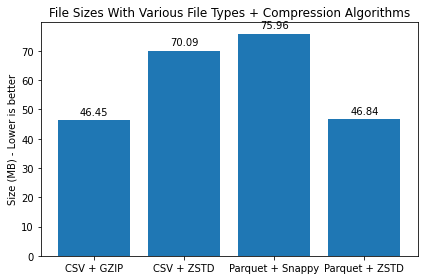

In [19]:
plt.figure()

x_labels = ['CSV + GZIP', 'CSV + ZSTD', 'Parquet + Snappy', 'Parquet + ZSTD']
y_sizes = [csv_size, zstd_txt_size, snappy_parquet_size, zstd_parquet_size]
size_converter = lambda size: round(size/(1024*1024), 2)

y_sizes = [size_converter(size) for size in y_sizes]


x = np.arange(len(x_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, y_sizes, width+0.45)

ax.set_ylabel('Size (MB) - Lower is better')
ax.set_title('File + Compression Type')
ax.set_xticks(x, x_labels)

ax.bar_label(rects, padding=3)

fig.tight_layout()

plt.title('File Sizes With Various File Types + Compression Algorithms')
plt.show()

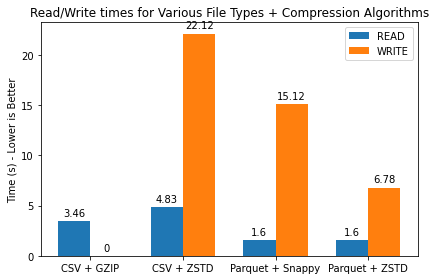

In [23]:
fig, ax = plt.subplots()

read_time = [csv_read_time, zstd_txt_read_time, snappy_read_time, zstd_parquet_read_time]
write_time = [0, zst_txt_write_time, snappy_write_time, zst_parquet_write_time]

rects1 = ax.bar(x - width/2, read_time, width, label='READ')
rects2 = ax.bar(x + width/2, write_time, width, label='WRITE')

ax.set_ylabel('Time (s) - Lower is Better')
ax.set_title('Operation')
ax.set_xticks(x, x_labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.title('Read/Write times for Various File Types + Compression Algorithms')
plt.show()

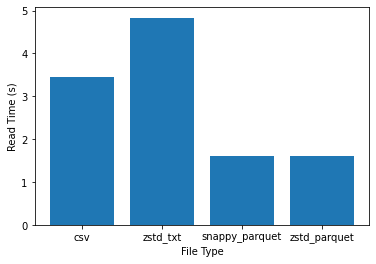

In [21]:
plt.bar(['csv', 'zstd_txt', 'snappy_parquet', 'zstd_parquet'], [csv_read_time, zstd_txt_read_time, snappy_read_time, zstd_parquet_read_time])
plt.xlabel('File Type')
plt.ylabel('Read Time (s)')

plt.show()

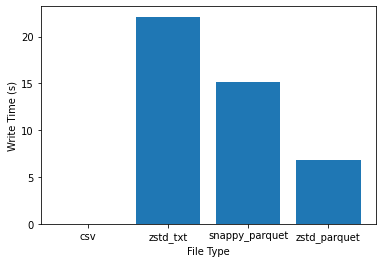

In [22]:
plt.bar(['csv', 'zstd_txt', 'snappy_parquet', 'zstd_parquet'], [0, zst_txt_write_time, snappy_write_time, zst_parquet_write_time])
plt.xlabel('File Type')
plt.ylabel('Write Time (s)')

plt.show()